# Evaluation

This notebook is meant to summarize the final results

In [171]:
# subsequent imports should work (with jupyter server started from interdisciplinary_project)
from pathlib import Path
cwd = Path.cwd()
save_dir = cwd / "final_evaluation"
save_dir.mkdir(parents=True, exist_ok=True)
print(cwd)


import torch
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score

import utils
from networks import GeneratorWithCondition, DiscriminatorWithCondition
from gans.cgan import CGAN
from cic_ids_17_dataset import CIC17Dataset
from utils import convert_levels_to_condition_vectors, labels_to_labelidx


sns.set_style("whitegrid")
sns.set_context("paper")
# sns.set_palette("Pastel1")
sns.set_palette("dark")
plt.rcParams['figure.figsize'] = (10, 6)

/Users/thomas/Google Drive/Colab Notebooks/TU/interdisciplinary_project


In [172]:
# palettes= ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
# tips = sns.load_dataset("tips")

# for p in palettes:
#     print(p)
#     sns.set_palette(p)
#     sns.barplot(x="day", y="total_bill", data=tips)
#     plt.show()

## Validate classifier predictions (dynamic condition vectors)

In [173]:
num_features, num_labels, condition_size = 79, 14, 41
condition_vector_dict = torch.load("data/cic-ids-2017_splits/seed_0/dynamic_condition_vector_dict.pt")

G = GeneratorWithCondition(num_features, num_labels, condition_size, latent_dim=128)
D = DiscriminatorWithCondition(num_features, condition_size)
gan = CGAN(G, D, None, None, use_dynamic_condition_vectors=True, condition_vector_dict=condition_vector_dict)
gan.load_model("models/cgan_with_dynamic_condition_vector/20-06-2021_08h09m/model-149.pt", load_optimizer=False)

classifier = joblib.load("./models/classifier/20-05-2021_12h01m/classifier.gz")
scaler = joblib.load("./data/cic-ids-2017_splits/seed_0/min_max_scaler.gz")
label_encoder = joblib.load("./data/cic-ids-2017_splits/seed_0/label_encoder.gz")

label_distribution = {0: 0.01, 1: 0.23, 2: 0.02, 3: 0.38, 4: 0.01, 5: 0.01, 6: 0.015,
                      7: 0.01, 8: 0.01, 9: 0.265, 10: 0.01, 11: 0.01, 12: 0.01, 13: 0.01}
label_weights = list(label_distribution.values())

Loaded G weights.
Loaded D weights.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
/Users/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                       Bot       0.83      0.34      0.49       102
                      DDoS       0.84      0.82      0.83      2352
             DoS GoldenEye       0.87      0.91      0.89       183
                  DoS Hulk       0.84      0.91      0.87      3738
          DoS Slowhttptest       0.35      0.75      0.47       110
             DoS slowloris       0.24      0.20      0.22       104
               FTP-Patator       0.92      0.79      0.85       141
                Heartbleed       0.00      0.00      0.00       107
              Infiltration       0.00      0.00      0.00       106
                  PortScan       0.98      0.99      0.98      2644
               SSH-Patator       0.89      0.54      0.67       109
  Web Attack  Brute Force       0.42      0.81      0.56       108
Web Attack  Sql Injection       0.00      0.00      0.00       102
          Web Attack  XSS       0.50      0.01

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


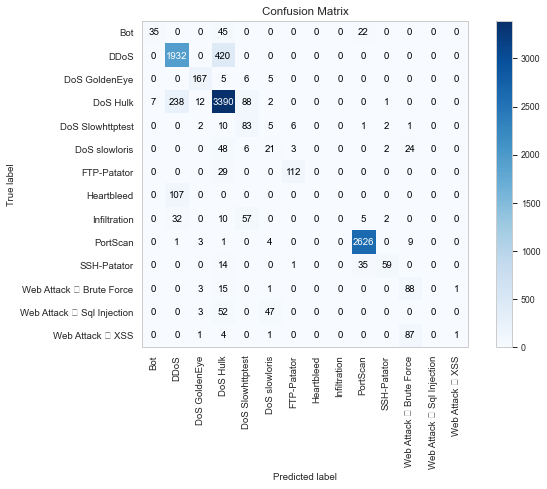

In [174]:
# 10000 random flows
flows, labels, condition_vectors = gan.generate(10000, label_weights, scaler=scaler, label_encoder=label_encoder)
label_preds = label_encoder.inverse_transform(classifier.predict(flows))
print(classification_report(labels, label_preds))
plot_confusion_matrix(labels, label_preds, x_tick_rotation=90)

### Validate dynamic condition vector level generation

We want to validate whether we can control the generation process. 

Therefore, we evaluate the condition for each feature (e.g. `Flow Duration`) indiviually. We have 3 kinds of features:
- features with three levels based on computes quantiles (low/mid/high) such as `Flow Duration`
- binary features, the flag features (e.g., `ACK Flag Count`)
- and the `Destination Port` feature that is mapped to its 16-bit representation

We examine each feature individually.


TBC

In [175]:
cgan_generation_control_dir = save_dir / "generation_control"
cgan_generation_control_dir.mkdir(parents=True, exist_ok=True)

#### Three-level features
First, we plot the three-level features. We compute 1000 flows per level per class (i.e., 30K flows per feature * 14 classes) and average their 
feature values to obtain the estimate of how well the output generation can be controlled. . 
The bars in the barplots represent the mean feature value for each level and the error bars show the 95% confidence interval. 

From the plots we see that overall, the GAN learns to control the generation process pretty well. For most feature and most classes we see a clear distinction between the three levels. 

(Additionally, we also compute TBD)



/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


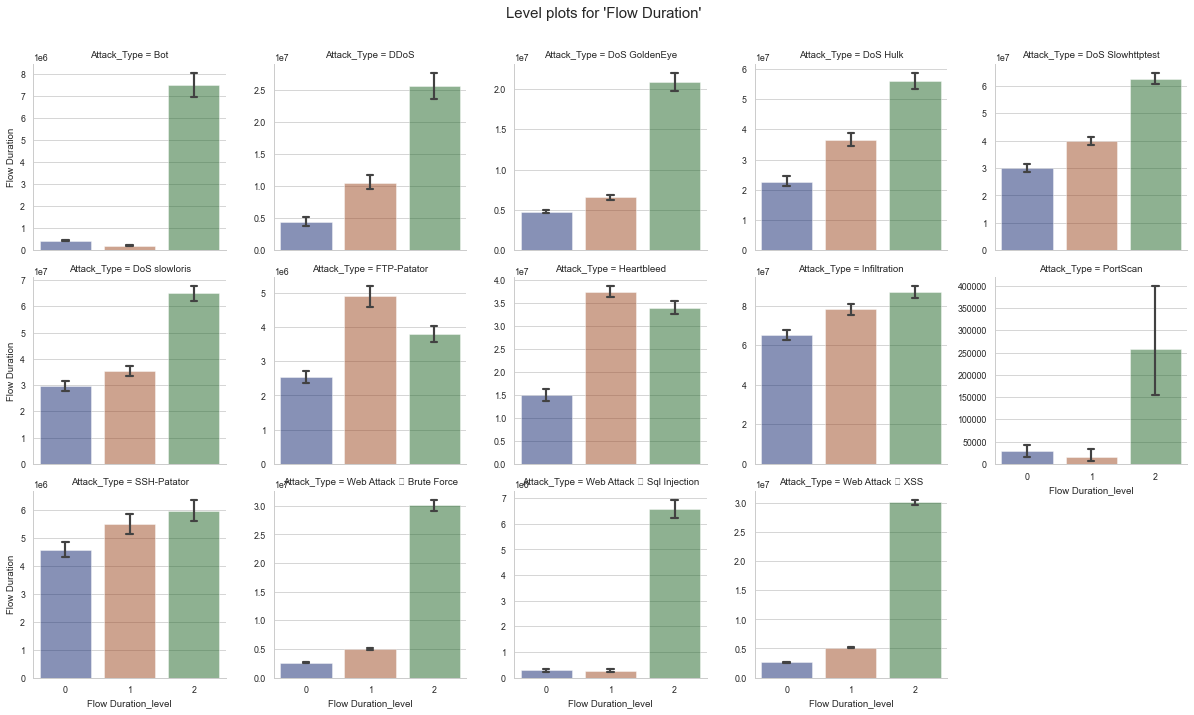

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


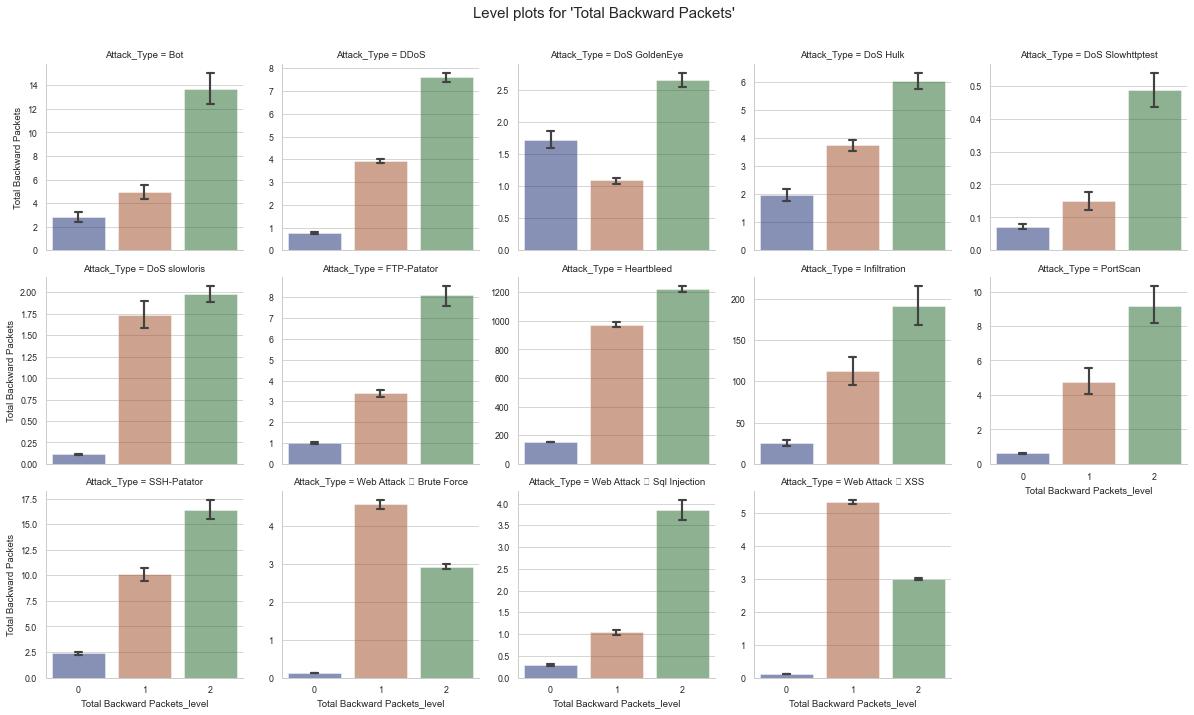

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


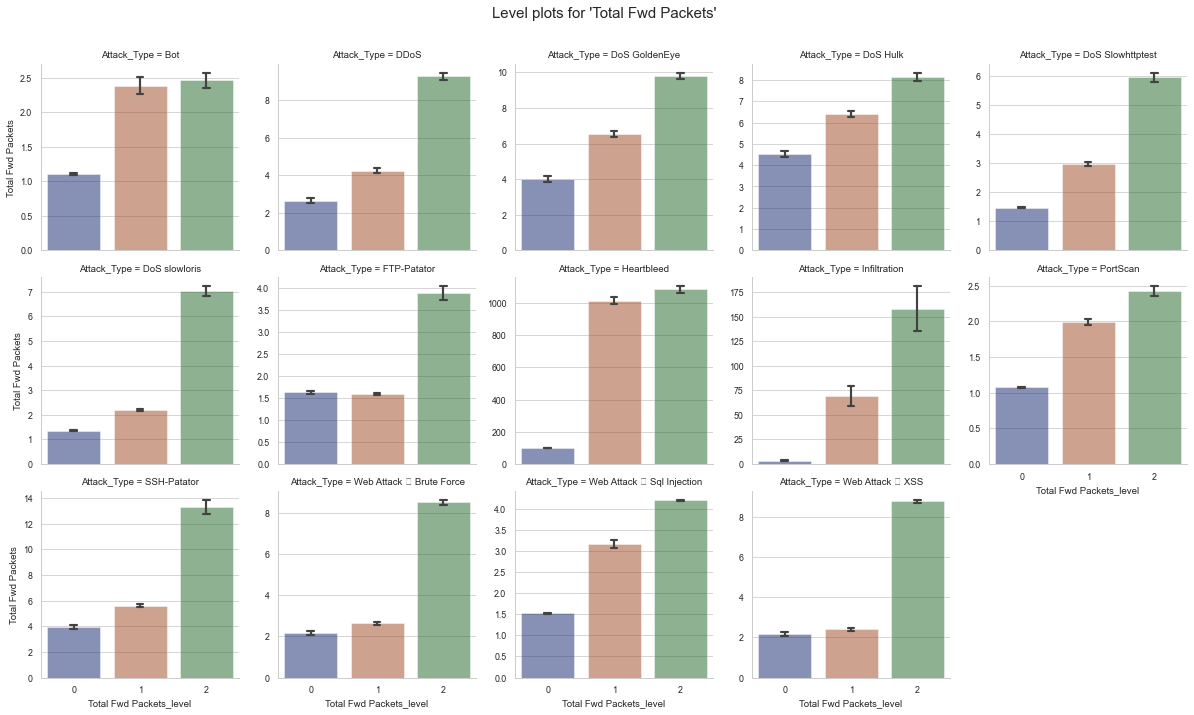

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


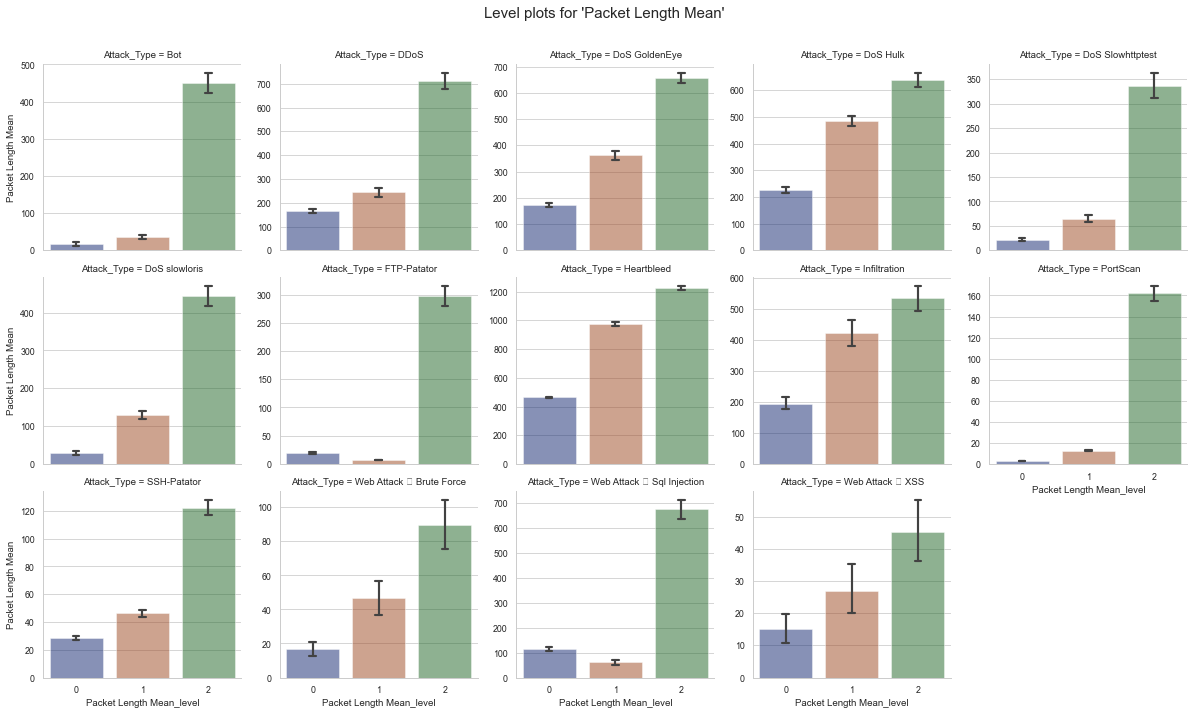

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


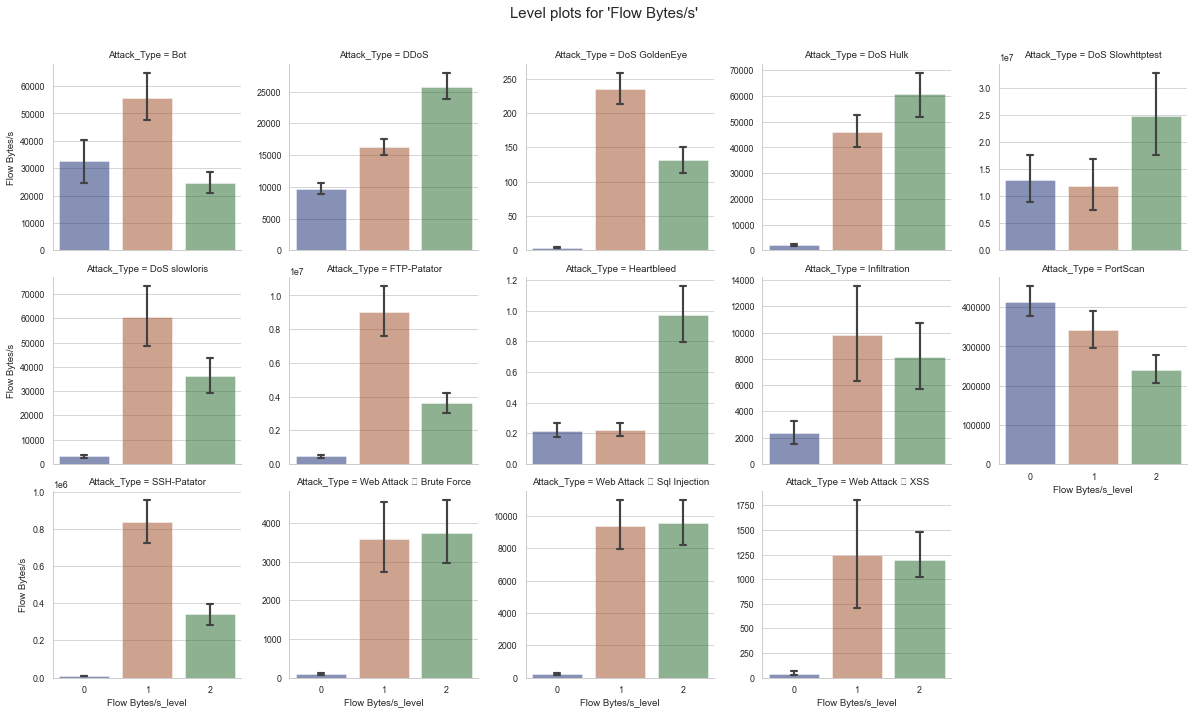

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


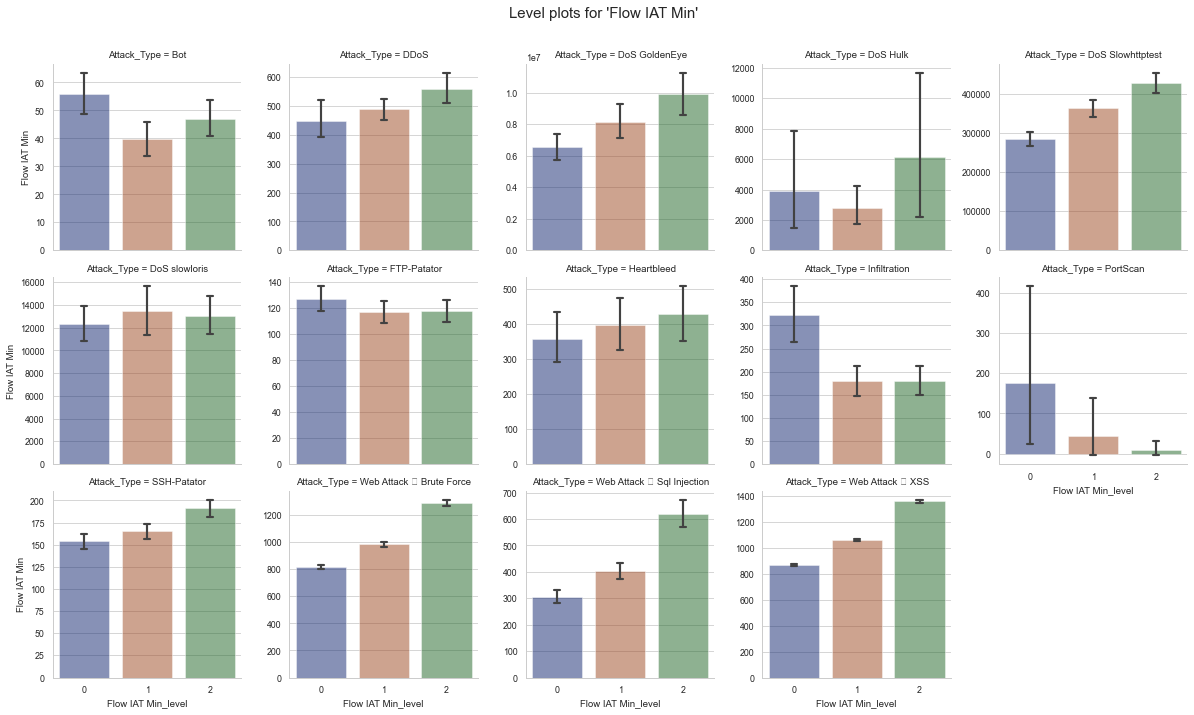

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


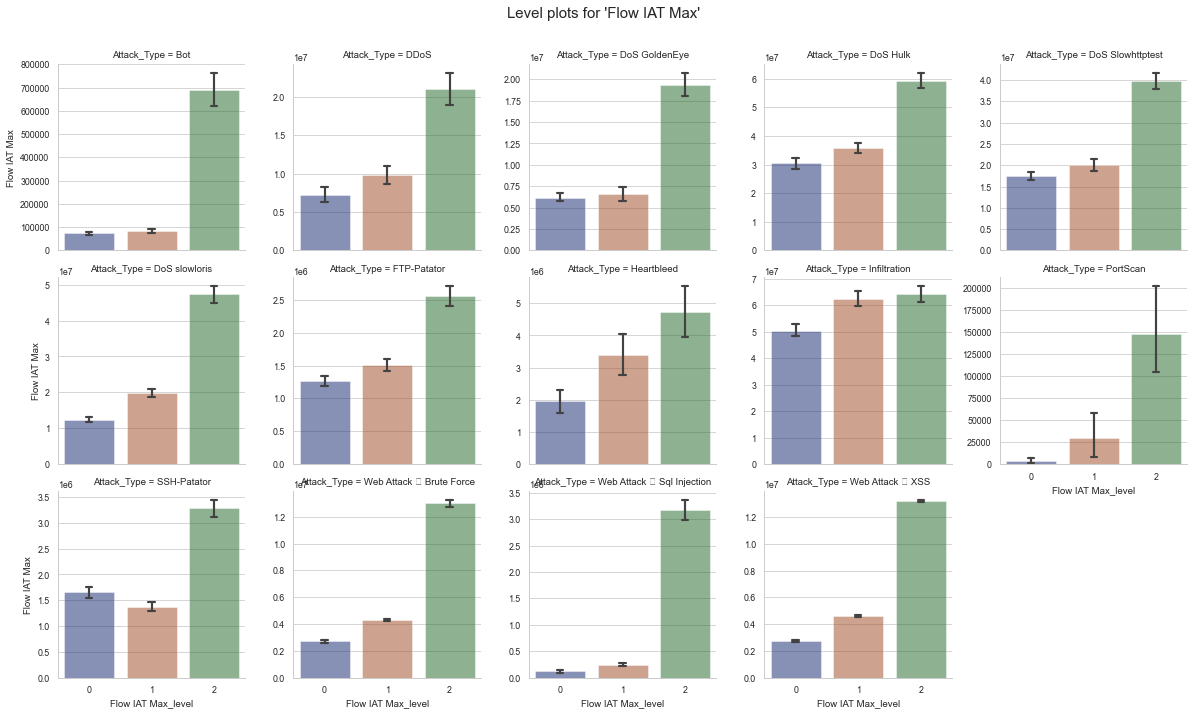

In [176]:
# setup 
n_flows_per_level = 1000
all_attacks = utils.get_label_names()[:-1]
attack_types = np.repeat(all_attacks, 3 * n_flows_per_level)
catplot_args = {
    "kind": "bar",
    "col_wrap": 5,
    "height": 3.3,
    "sharey": False,
    "ci": 95,
    "capsize":0.1,  # controls the size of horizontal lines in errorbars
    "alpha": 0.5
}


# generate 
features = ['Flow Duration', 'Total Backward Packets', 'Total Fwd Packets', 'Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Min', 'Flow IAT Max']
for feature in features:
    levels = [{feature: 0}, {feature: 1},  {feature: 2}] * n_flows_per_level * len(all_attacks)
    df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)

    ax = sns.catplot(
        x=feature + "_level",
        y=feature, 
        col="Attack_Type", 
        data=df_results,
        **catplot_args
    )
    ax.fig.subplots_adjust(top=0.9)
    ax.fig.suptitle(f"Level plots for '{feature}'", fontsize=15)
    ax.savefig(f"{cgan_generation_control_dir / feature.replace('/', '')}.png")
    plt.show()

#### Binary features (flags)

Next, we visualize the generation process for the binary flag features. (`0=flag, 1=no_flag`)

The GAN produces real-value outputs, hence the produced values for the flags is in range [0, 1]. Therefore, it is not exactly 0 or 1 in most cases. For this reason we also round the generated outputs.
Next, we plot generated outputs using countplots. The blue bars represent the total number of 0s (`flag`) that were generated. Likewise, the organge bars represent the total number of 1s (`no_flag`) that were generated. The inputs to the GAN represent 50% `flags` and 50% `no_flag`. Hence, if it does well the bars should be of the same length.

We see that overall, the model is partly able to distinguish between "flag"/"no-flag" inputs. However, we also see that it is much more likely to produce "no-flag" than "flag". One reason for this is that Flags seldom occur in the dataset and hence it is biased towards not generating it. This also depends on the flag type. For example, `RST Flag` is never present in the dataset, therefore the model does not generate it at all, even if it is tasked to. 


However, the visualization is suboptimal. Therefore we also compute the "generation" accuracy and f1-scores, i.e., if the task is to produce flows with flags, how many of the generated flows contain flags. 


/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


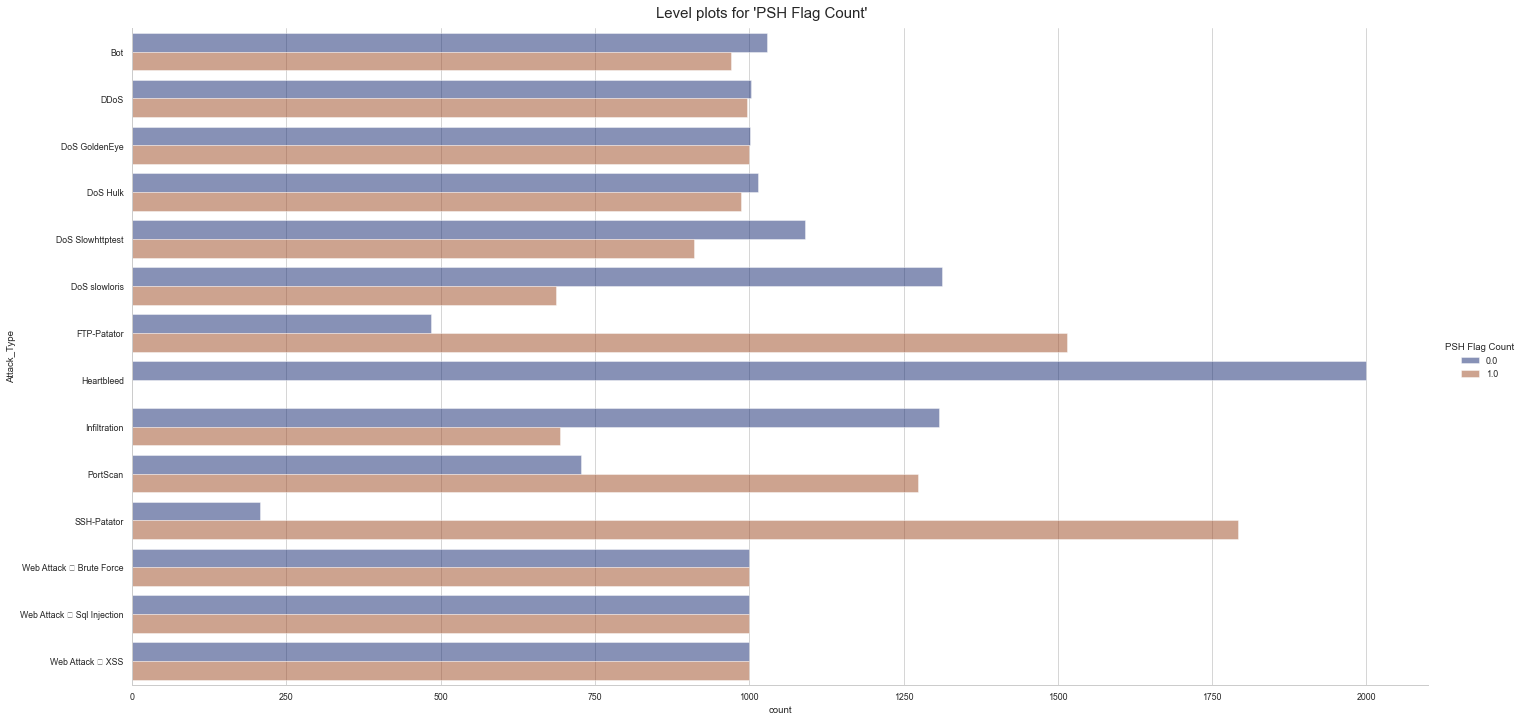

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


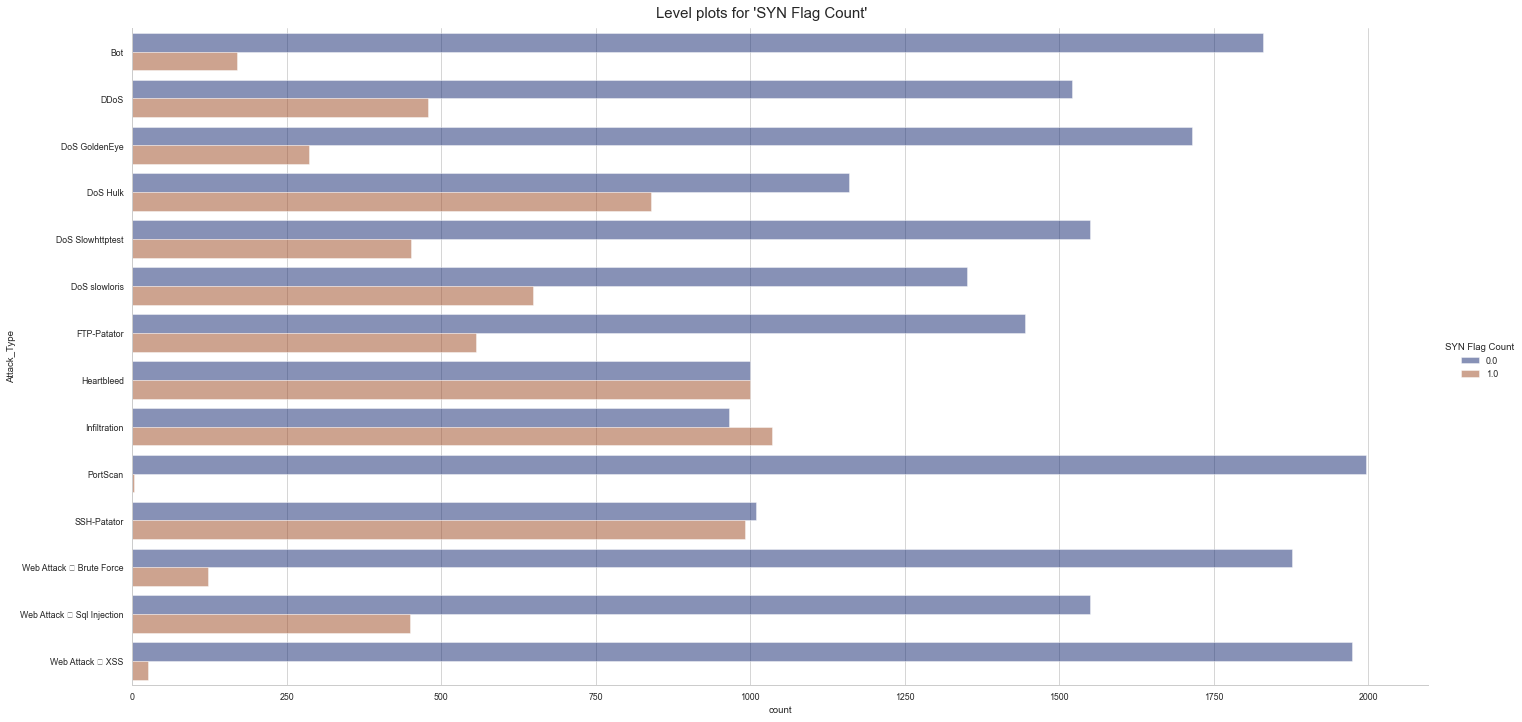

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


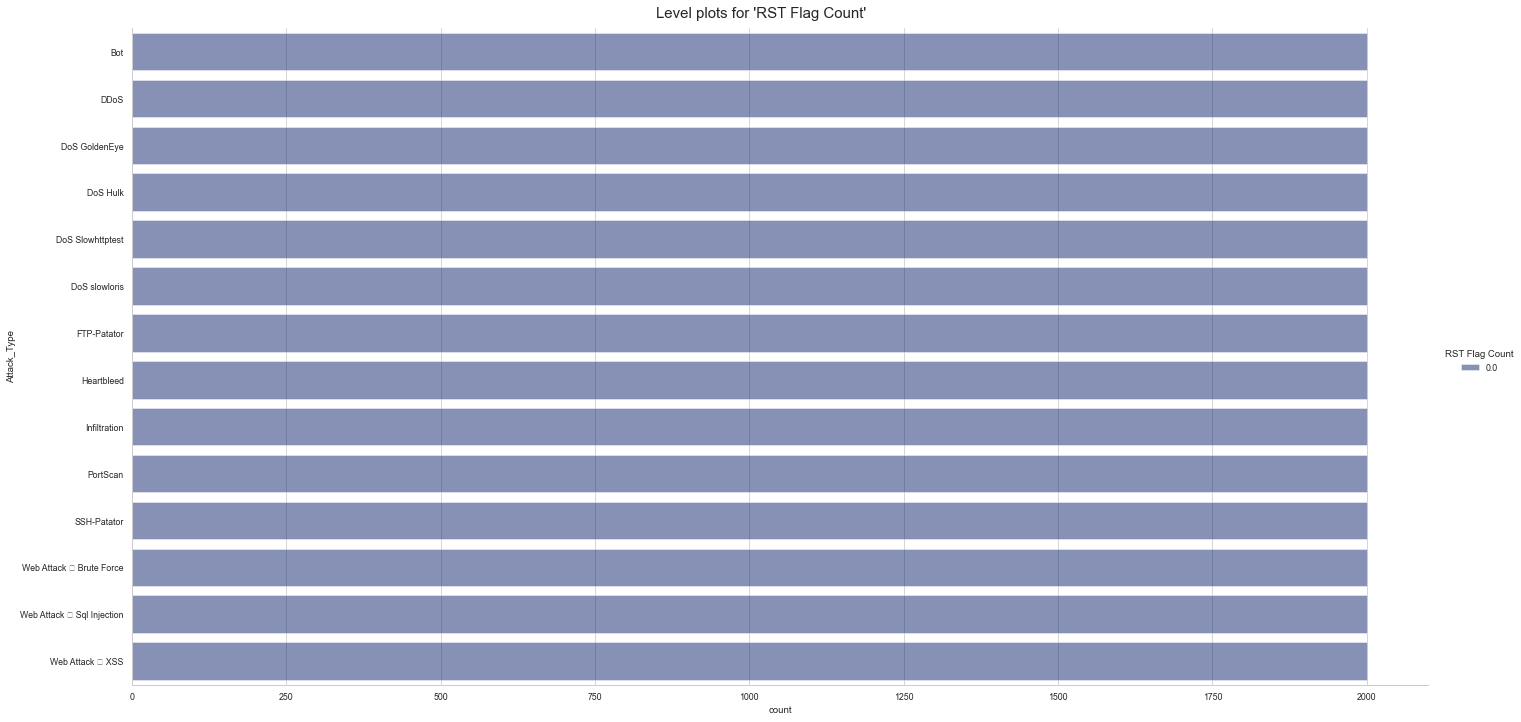

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


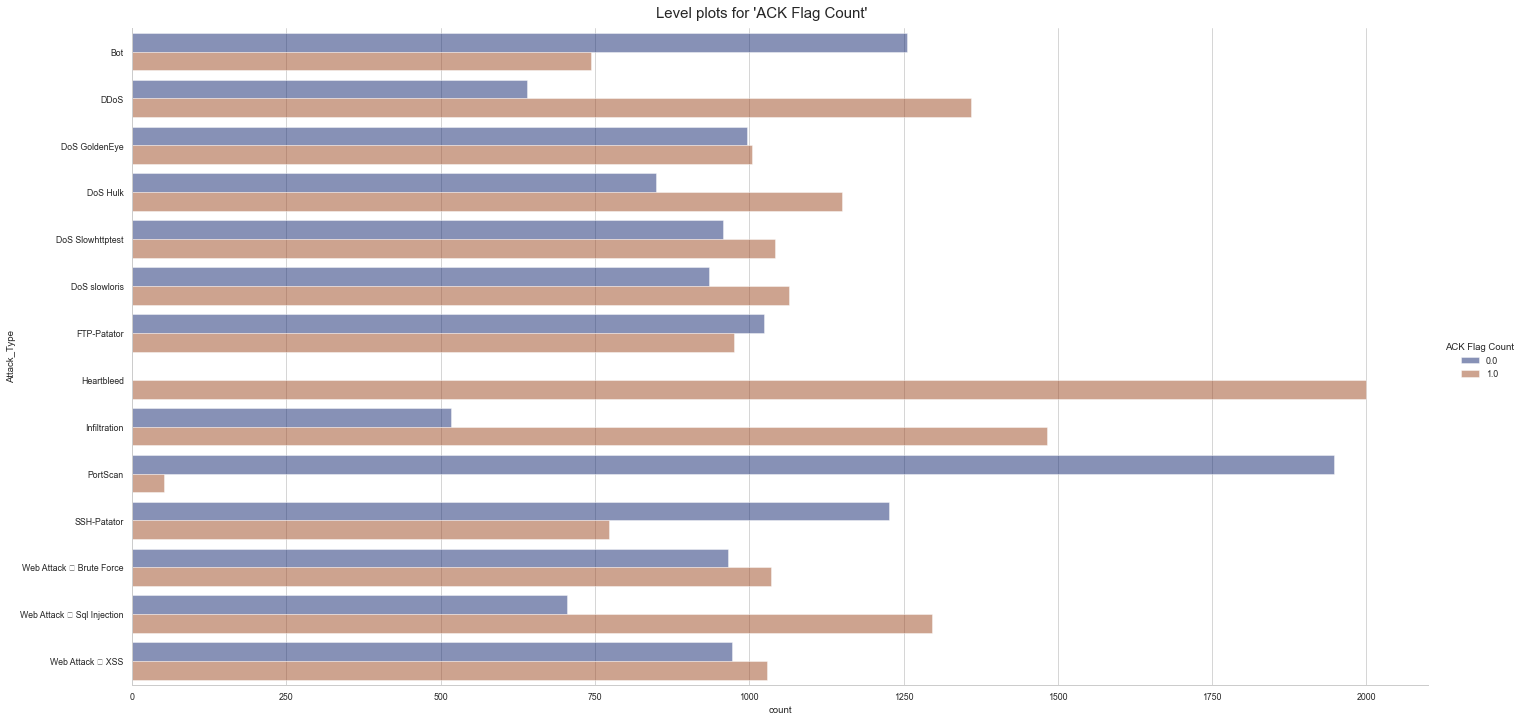

In [177]:
# generate 
n_flows_per_level = 1000
all_attacks = utils.get_label_names()[:-1]
attack_types = np.repeat(all_attacks, 2 * n_flows_per_level)
catplot_args = {
    "kind": "count",
    "height": 10,
    "aspect": 2,
    "alpha": 0.5,
}

flag_scores = []
flag_features = ['PSH Flag Count', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count']
for feature in flag_features:
    levels = [{feature: 0}, {feature: 1}] * n_flows_per_level * len(all_attacks)
    df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
    df_results[feature] = df_results[feature].round()
        
    ax = sns.catplot(
        y="Attack_Type",
        hue=feature, 
        # col=feature+"_level",
        data=df_results,
        **catplot_args
    )
    ax.fig.subplots_adjust(top=0.95)
    ax.fig.suptitle(f"Level plots for '{feature}'", fontsize=15)
    ax.savefig(f"{cgan_generation_control_dir / feature.replace('/', '')}.png")
    plt.show()
    
    for attack in all_attacks:
        df_temp = df_results[df_results["Attack_Type"] == attack]
        f1 = f1_score(df_temp[feature + '_level'], df_temp[feature])
        acc = accuracy_score(df_temp[feature + '_level'], df_temp[feature])
        flag_scores.append({"Feature": feature, "Attack_Type": attack, "F1": f1, "Accuracy": acc})
        
flag_scores = pd.DataFrame(flag_scores)

Overall, we see that the prediciton accuracy is relatively high for `PSH Flag Count`, moderately high for `ACK Flag Count` and `SYN Flag Count`, but random for `RST Flag Count`.

In [178]:
display(
    flag_scores.groupby("Feature").mean(),
    flag_scores.groupby("Attack_Type").mean(),
    flag_scores.mean()
)

,F1,Accuracy
Feature,,
ACK Flag Count,0.756894,0.773821
PSH Flag Count,0.853686,0.880679
RST Flag Count,0.000000,0.500000
SYN Flag Count,0.590628,0.747964


,F1,Accuracy
Attack_Type,,
Bot,0.504464,0.711375
DDoS,0.622999,0.764000
DoS GoldenEye,0.592360,0.766875
DoS Hulk,0.703553,0.829375
DoS Slowhttptest,0.604419,0.755125
DoS slowloris,0.629455,0.770625
FTP-Patator,0.499940,0.629125
Heartbleed,0.416667,0.625000
Infiltration,0.641063,0.758625


F1          0.550302
Accuracy    0.725616
dtype: float64

To set the results in contrast, we actually have to compute the proportions of flag usage in the original dataset. In this evaluation we used a 50% flows with flags and 50% flags without flags. We see that in the original dataset `RST Flag Count` is always 0. Hence, the model has no chance to learn this relation (we could have dropped this feature, but this nicely shows the difference). For `PSH Flag Count` and `ACK Flag Count` we see that for about half of the flows the flags is present and for half of them it is not. Finally we see that for `SYN Flag Count` the flag is hardly present. Our results reflect this well. 

In [179]:
train_dataset = CIC17Dataset(
    "./data/cic-ids-2017_splits/seed_0/train_dataset.pt",
    is_scaled=False
)
df_train = pd.DataFrame(np.append(train_dataset.X, train_dataset.y.reshape(-1, 1), axis=1), columns=train_dataset.column_names)
df_train["Label"] = train_dataset.label_encoder.inverse_transform(df_train["Label"].astype(int))

In [180]:
df_train[flag_features + ["Label"]].describe().round(3)

,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
count,528728.000,528728.000,528728.0,528728.000
mean,0.462,0.012,0.0,0.432
std,0.499,0.109,0.0,0.495
min,0.000,0.000,0.0,0.000
25%,0.000,0.000,0.0,0.000
50%,0.000,0.000,0.0,0.000
75%,1.000,0.000,0.0,1.000
max,1.000,1.000,0.0,1.000


If we look at the proportions for each class separately, we can also see why the model does "poorly" for some attack types. For example, for `Bot, DDoS, DoS GoldenEye, DoS Hulk, Heartbleed, Web Attack Brute Force, Web Attack Sql Injection and Web Attack XSS` the `SYN Flag` is never set. Therefore, the model actually does the right thing when it resists to set the flag.

In [181]:
df_train.groupby("Label")[flag_features].mean().round(3)

,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
Label,,,,
Bot,0.622,0.000,0.0,0.378
DDoS,0.455,0.000,0.0,0.546
DoS GoldenEye,0.716,0.000,0.0,0.286
DoS Hulk,0.064,0.000,0.0,0.681
DoS Slowhttptest,0.766,0.163,0.0,0.234
DoS slowloris,0.670,0.316,0.0,0.330
FTP-Patator,0.502,0.496,0.0,0.498
Heartbleed,0.091,0.000,0.0,0.909
Infiltration,0.176,0.559,0.0,0.824


#### Destination Port feature